In [352]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import yeojohnson
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, GridSearchCV
from DensityAwareClustering import DensityAwareClustering
import shap
import os

In [353]:
datapath = "/Users/halvornedrebo/Documents/Programmering/INFO381/data/"

In [354]:
le = LabelEncoder()

def clean_data(filename):

    print("Importing data...")
    data = pd.read_csv(datapath+filename, index_col=0)

    # Separate majority and minority classes
    df_majority = data[data['is_fraud'] == 0]
    df_minority = data[data['is_fraud'] == 1]

    # Downsample majority class to match the minority class size (or a bit more if you like)
    df_majority_downsampled = df_majority.sample(n=10000, random_state=42)

    # Combine minority class with downsampled majority
    df_balanced = pd.concat([df_minority, df_majority_downsampled])

    # Shuffle the dataset
    data = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    print("splitting time columns...")
    data["trans_date_trans_time"] = pd.to_datetime(data["trans_date_trans_time"])

    data['trans_minute'] = data['trans_date_trans_time'].dt.minute
    data['trans_hour'] = data['trans_date_trans_time'].dt.hour
    data['trans_day'] = data['trans_date_trans_time'].dt.day
    data['trans_month'] = data['trans_date_trans_time'].dt.month
    data['trans_year'] = data['trans_date_trans_time'].dt.year
    data['trans_dayofweek'] = data['trans_date_trans_time'].dt.dayofweek

    data["dob"] = pd.to_datetime(data["dob"])
    data["dob_day"] = data["dob"].dt.day
    data["dob_month"] = data["dob"].dt.month
    data["dob_year"] = data["dob"].dt.year

    print("Dropping columns...")
    data = data.drop(["cc_num","long", "merch_long", "lat", 
                      "merch_lat", "unix_time", 
                      "trans_date_trans_time",
                      "first", "last", "dob","trans_num"
                      ], axis=1)
    
    print("Rounding columns...")
    data[["trans_minute", "trans_hour", "trans_day", "trans_month", "trans_year", "trans_dayofweek", "dob_year", "dob_month", "dob_day", "city_pop", "zip"]] = data[["trans_minute", "trans_hour", "trans_day", "trans_month", "trans_year", "trans_dayofweek", "dob_year", "dob_month", "dob_day", "city_pop", "zip"]].round(decimals=0)

    data["amt"] = data["amt"].round(decimals=2)

    cat_data = data.select_dtypes(include=["object"])

    print(data.columns)

    print("Encoding categorical features...")
    label_encoders = {}
    inverse_mappings = {}

    for col in cat_data.columns:
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
        inverse_mappings[col] = dict(zip(le.transform(le.classes_), le.classes_))

    print("Rounding categorical columns...")
    data[["merchant", "category", "street", "city", "state", "job"]] = data[["merchant", "category", "street", "city", "state", "job"]].round(decimals=0)

    
    print(data.head())


    return data, inverse_mappings

In [355]:
data, inverse_mappings = clean_data("fraud.csv")  

Importing data...
splitting time columns...
Dropping columns...
Rounding columns...
Index(['merchant', 'category', 'amt', 'gender', 'street', 'city', 'state',
       'zip', 'city_pop', 'job', 'is_fraud', 'trans_minute', 'trans_hour',
       'trans_day', 'trans_month', 'trans_year', 'trans_dayofweek', 'dob_day',
       'dob_month', 'dob_year'],
      dtype='object')
Encoding categorical features...
Rounding categorical columns...
   merchant  category     amt  gender  street  city  state    zip  city_pop  \
0       365         2   70.61       1     264   794     27  27358     14075   
1       179        12   68.16       1     742   634     17  42634      1565   
2        78         7  133.34       1     939   604      4  94619    381459   
3       586         0  614.72       0     534    47     41  57426        63   
4       304        11  997.39       1     454   194     43  75210   1263321   

   job  is_fraud  trans_minute  trans_hour  trans_day  trans_month  \
0   56         0      

In [356]:

X = data.drop("is_fraud", axis=1)
y = data["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [357]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda")

model.fit(X_train, y_train)

/Users/halvornedrebo/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:44:04] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [358]:
y_pred = model.predict(X_test)
xgb_rmse = np.sqrt(MSE(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

print(f"RMSE: {xgb_rmse:.2f}")
print(classification_report(y_test, y_pred))
print(cm)

RMSE: 0.15
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1985
           1       0.98      0.98      0.98      1946

    accuracy                           0.98      3931
   macro avg       0.98      0.98      0.98      3931
weighted avg       0.98      0.98      0.98      3931

[[1942   43]
 [  42 1904]]


<Figure size 1000x800 with 0 Axes>

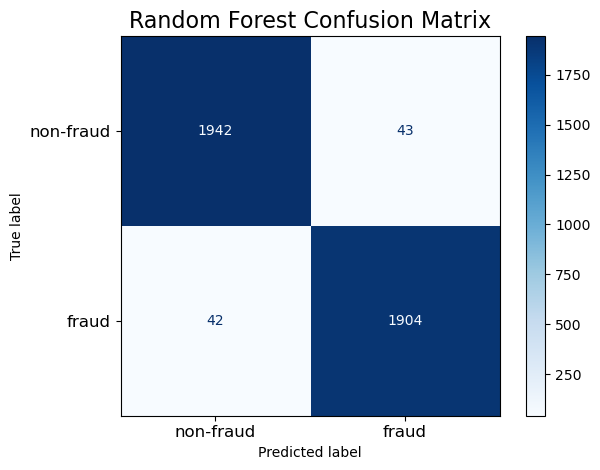

In [359]:
class_names = ["non-fraud", "fraud"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("confusion_matrix.png", bbox_inches='tight')

In [360]:
explainer = shap.TreeExplainer(model)
explanation = explainer(X_test)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - y_pred).max()

13.108084678649902

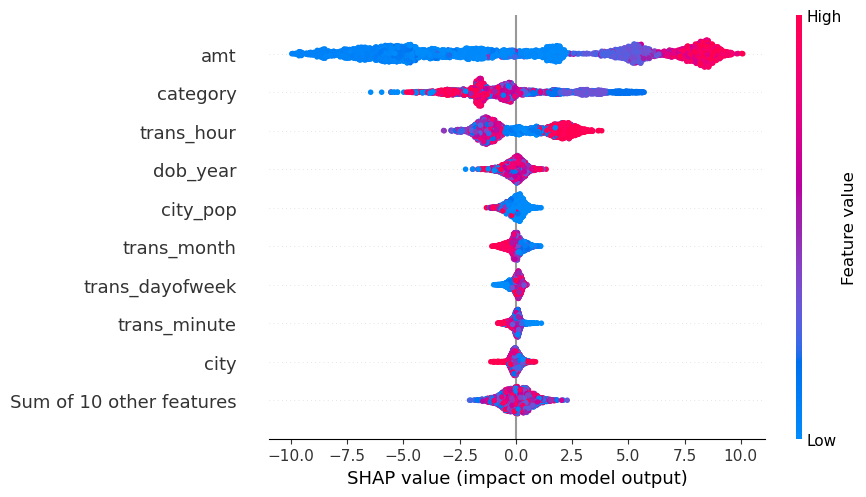

In [361]:
shap.plots.beeswarm(explanation)

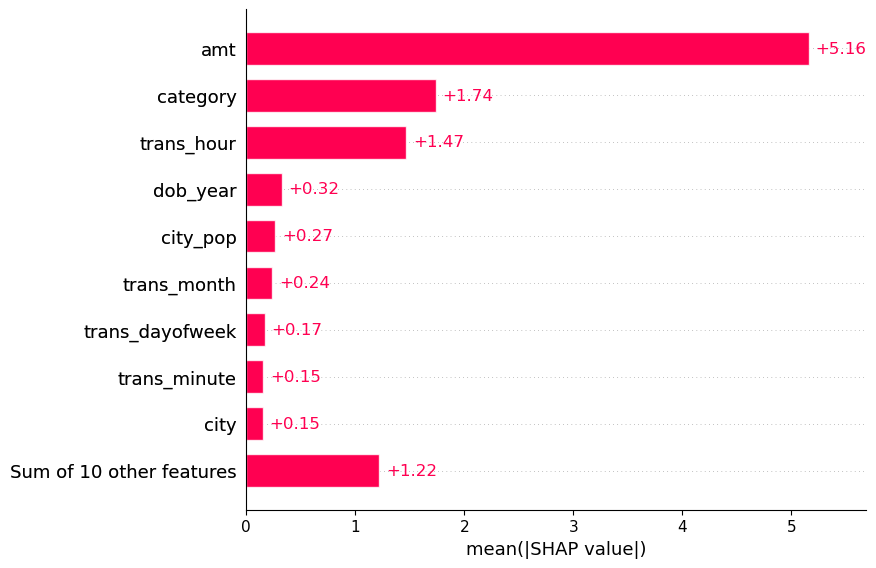

In [362]:
shap.plots.bar(explanation)

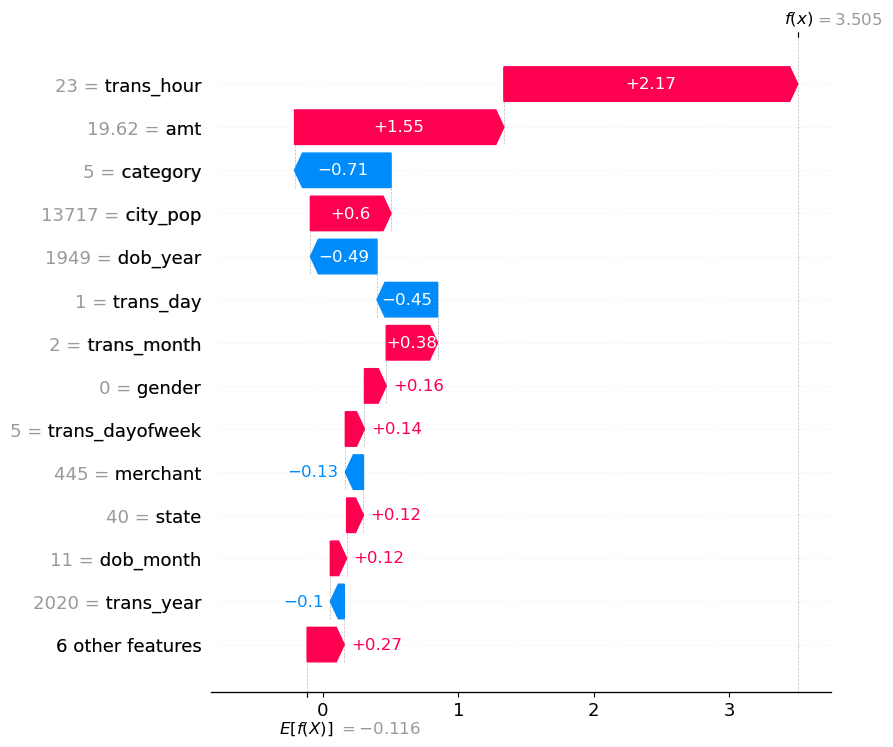

In [363]:
shap.plots.waterfall(explanation[100], max_display=14)

In [364]:
category_map = {
    data.columns.get_loc(col): list(mapping.values())
    for col, mapping in inverse_mappings.items()
}


In [365]:
from alibi.explainers import AnchorTabular
feature_names = X_train.columns.tolist()
predict_fn = lambda x: model.predict_proba(x)
#predict_fn = lambda x: model.predict(le.transform(x))

In [366]:
explainer = AnchorTabular(predict_fn, feature_names, categorical_names=category_map)

In [367]:
explainer.fit(X_train.to_numpy(), disc_perc=(10, 25, 50, 75, 90)
)


AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (10, 25, 50, 75, 90)},
  'version': '0.9.6'}
)

In [368]:
instance = X_test.iloc[15].to_numpy()
explanation = explainer.explain(instance, threshold=0.90, beam_size=10)


In [369]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: amt > 422.02
Precision: 0.97
Coverage: 0.25
